[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/dbsn-import/blob/main/townhalls/townhalls_dbsn.ipynb)
<!--[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/dbsn-import/blob/main/townhalls/townhalls_dbsn.ipynb)-->

# Finding missing town halls in Italy

## Step 1: State Of The Art analysis

### Configuration

In [1]:
SEARCH_AREA_ID = 3600365331 # Italia
#SEARCH_AREA_ID = 3600042611 # Emilia-Romagna
#SEARCH_AREA_ID = 3600040218 # Campania
# ID calculated with https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_element_id

In [2]:
PROVINCES_FILE_PATH = f"./provinces_{SEARCH_AREA_ID}.4326.parquet"
MUNICIPALITIES_FILE_PATH = f"./municipalities_{SEARCH_AREA_ID}.4326.parquet"
TOWNHALLS_FILE_PATH = f"./townhalls_{SEARCH_AREA_ID}.4326.parquet"
BAD_TOWNHALLS_FILE_PATH = f"./bad_townhalls_{SEARCH_AREA_ID}.4326.geojson"
WITHOUT_TOWNHALL_FILE_PATH = f"./without_townhall_{SEARCH_AREA_ID}.4326.geojson"
DBSN_FILE_PATH = f"./townhalls.fgb"
DBSN_CONFLICTS_FILE_PATH = f"./dbsn_conflicts_{SEARCH_AREA_ID}.4326.geojson"
DBSN_MISSING_FILE_PATH = f"./dbsn_missing_{SEARCH_AREA_ID}.4326.geojson"
UNTAGGED_FILE_PATH = f"./untagged_{SEARCH_AREA_ID}.4326.geojson"
UNTAGGED_MISSING_FILE_PATH = f"./untagged_missing_{SEARCH_AREA_ID}.4326.geojson"

### Setup

In [3]:
%pip install geopandas contextily pyproj rtree shapely mapclassify branca folium pyarrow

  Using cached contextily-1.7.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached geographiclib-2.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached contextily-1.7.0-py3-none-any.whl (16 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.1-py3-none-any.whl (40 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Using cached click-8.3.1-py3-none-any.whl (108 kB)
   ---------------------------------------- 0.0/25.7 MB ? eta -:--:--
   --- ------------------------------------ 2.1/25.7 MB 30.2 MB/s eta 0:00:01
   -------------- ------------------------- 9.2/25.7 MB 3

In [4]:
from pandas import merge, Series
from geopandas import GeoDataFrame, read_file, read_parquet
from shapely.geometry import GeometryCollection, shape, Point, MultiPolygon, LineString
from shapely.ops import polygonize
from urllib.request import urlopen, urlretrieve
from urllib.error import HTTPError
from urllib.parse import quote_plus
from os.path import exists
import contextily as cx
import json
from numpy import array
from os import system

### Download municipalities and existing town halls from Overpass

In [5]:
PROVINCE_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({SEARCH_AREA_ID})->.searchArea;
(
    relation["boundary"="administrative"]["admin_level"="6"]["ISO3166-2"!="FR-74"](area.searchArea);
    relation["boundary"="administrative"]["admin_level"="4"]["ISO3166-2"="IT-23"](area.searchArea);
);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [6]:
MUNICIPALITY_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({SEARCH_AREA_ID})->.searchArea;
relation["boundary"="administrative"]["admin_level"="8"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [7]:
TOWNHALL_OVERPASS_QUERY=f"""
[out:json][timeout:90];
area({SEARCH_AREA_ID})->.searchArea;
nwr["amenity"="townhall"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [8]:
def fetchOverpassGeoDataFrame(overpass_query:str, geometry_transform=shape):
    url = "https://overpass-api.de/api/interpreter?data="+quote_plus(overpass_query)
    try:
        with urlopen(url) as response:
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            json_content = data.decode(encoding)
        if "Query timed out" in json_content:
            raise Exception("Query timed out")
        #print(json_content)
        json_object = json.loads(json_content)
        #print(json_object['elements'][0] if json_object['elements'] else "No elments")
        elements = [{
            "id": element["id"],
            "osm_id": element["tags"]["_osm_id"],
            "osm_type": element["tags"]["_osm_type"],
            "osm_url": 'https://www.openstreetmap.org/'+element["tags"]["_osm_type"]+'/'+element["tags"]["_osm_id"],
            "name": element["tags"]["name"] if "name" in element["tags"] else None,
            "geometry": geometry_transform(element['geometry'])
        } for element in json_object['elements']]
        #print(elements[0])
        # OSM uses WGS 84: https://wiki.openstreetmap.org/wiki/Converting_to_WGS84
        crs = 'EPSG:4326' # Use the SRID for WGS 84 - https://epsg.io/4326
        gdf = GeoDataFrame(elements, crs=crs)
    except HTTPError as err:
        print("Failed downloading data from Overpass, retry later")
        raise err
    except json.JSONDecodeError as err:
        print("Failed interpreting JSON data from Overpass")
        raise err
    return gdf

In [9]:
def readOrFetchOverpassGeoDataFrame(file_path:str, overpass_query:str, geometry_transform=shape):
    if exists(file_path):
        if file_path.endswith(".parquet"):
            gdf = read_parquet(file_path)
        else:
            gdf = read_file(file_path, driver='GeoJSON')
    else:
        gdf = fetchOverpassGeoDataFrame(overpass_query, geometry_transform)
        if file_path.endswith(".parquet"):
            gdf.to_parquet(file_path)
        else:
            gdf.to_file(file_path, driver='GeoJSON')
    return gdf

In [10]:
# Convert Overpass geometries into MultiPolygons - https://stackoverflow.com/a/72677231/2347196
convert_geom_to_multipolygon = lambda x: MultiPolygon(polygonize(shape(x)))

In [11]:
province_gdf = readOrFetchOverpassGeoDataFrame(PROVINCES_FILE_PATH, PROVINCE_OVERPASS_QUERY, convert_geom_to_multipolygon)
province_gdf.count()

id          110
osm_id      110
osm_type    110
osm_url     110
name        110
geometry    110
dtype: int64

In [12]:
province_gdf.head()

id    osm_id  osm_type                                          osm_url  \
0   1     39151  relation     https://www.openstreetmap.org/relation/39151   
1   2     39979  relation     https://www.openstreetmap.org/relation/39979   
2   3     40021  relation     https://www.openstreetmap.org/relation/40021   
3   4    276369  relation    https://www.openstreetmap.org/relation/276369   
4   5  19622159  relation  https://www.openstreetmap.org/relation/19622159   

                 name                                           geometry  
0           Agrigento  MULTIPOLYGON (((13.98172 37.19299, 13.98217 37...  
1               Nuoro  MULTIPOLYGON (((9.82243 40.53994, 9.82245 40.5...  
2  Aristanis/Oristano  MULTIPOLYGON (((8.38245 40.3386, 8.38324 40.33...  
3   Casteddu/Cagliari  MULTIPOLYGON (((9.13723 39.19159, 9.1353 39.19...  
4   Sulcis Iglesiente  MULTIPOLYGON (((8.2076 39.1476, 8.20768 39.147...

In [13]:
municipality_gdf = readOrFetchOverpassGeoDataFrame(MUNICIPALITIES_FILE_PATH, MUNICIPALITY_OVERPASS_QUERY, convert_geom_to_multipolygon)
municipality_gdf.count()

id          7896
osm_id      7896
osm_type    7896
osm_url     7896
name        7896
geometry    7896
dtype: int64

In [14]:
municipality_gdf.head()

id osm_id  osm_type                                       osm_url  \
0   1  39150  relation  https://www.openstreetmap.org/relation/39150   
1   2  39777  relation  https://www.openstreetmap.org/relation/39777   
2   3  39809  relation  https://www.openstreetmap.org/relation/39809   
3   4  39853  relation  https://www.openstreetmap.org/relation/39853   
4   5  39915  relation  https://www.openstreetmap.org/relation/39915   

                         name  \
0          Lampedusa e Linosa   
1  Santu Antiogu/Sant'Antioco   
2         Câdesédda/Calasetta   
3           Igrèsias/Iglesias   
4            Bugerru/Buggerru   

                                            geometry  
0  MULTIPOLYGON (((12.87805 35.85517, 12.87809 35...  
1  MULTIPOLYGON (((8.38404 39.00591, 8.38379 39.0...  
2  MULTIPOLYGON (((8.3749 39.10915, 8.37532 39.10...  
3  MULTIPOLYGON (((8.43347 39.30784, 8.43347 39.3...  
4  MULTIPOLYGON (((8.41075 39.4413, 8.41059 39.44...

In [15]:
townhall_gdf = readOrFetchOverpassGeoDataFrame(TOWNHALLS_FILE_PATH, TOWNHALL_OVERPASS_QUERY)
townhall_gdf.count()

id          8360
osm_id      8360
osm_type    8360
osm_url     8360
name        6653
geometry    8360
dtype: int64

In [16]:
townhall_gdf.head()

id       osm_id osm_type                                         osm_url  \
0   1   4492704609     node   https://www.openstreetmap.org/node/4492704609   
1   2  12065011046     node  https://www.openstreetmap.org/node/12065011046   
2   3   1853454108     node   https://www.openstreetmap.org/node/1853454108   
3   4   5358907076     node   https://www.openstreetmap.org/node/5358907076   
4   5   2126087185     node   https://www.openstreetmap.org/node/2126087185   

                             name                  geometry  
0            Comune di Carloforte  POINT (8.30562 39.14578)  
1            Comune di Portoscuso  POINT (8.37899 39.20365)  
2               Comune di Teulada   POINT (8.77381 38.9679)  
3          Comune di Sant'Antioco  POINT (8.45543 39.06645)  
4  Comune di San Giovanni Suergiu  POINT (8.52207 39.11028)

In [17]:
from matplotlib import pyplot as plt
def show_map(geo_df:GeoDataFrame, background_gdf:GeoDataFrame=None, color_column:str=None, cmap:str=None):
    df_wm = geo_df.to_crs(epsg=3857)
    figsize=(20,10)
    fig,ax = plt.subplots(1, 1, figsize=figsize)
    legend = False
    
    if background_gdf is not None:
        background_df_wm = background_gdf.to_crs(epsg=3857)
        ax = background_df_wm.plot(ax=ax, figsize=figsize, alpha=0.3, edgecolor='k')
    
    if color_column is not None:
        legend = True
    
    ax = df_wm.plot(ax=ax, figsize=figsize, edgecolor='k', column=color_column, cmap=cmap, legend=legend)
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

Map of municipalities available on OSM:

In [18]:
show_map(municipality_gdf)

Map of town halls available on OSM:

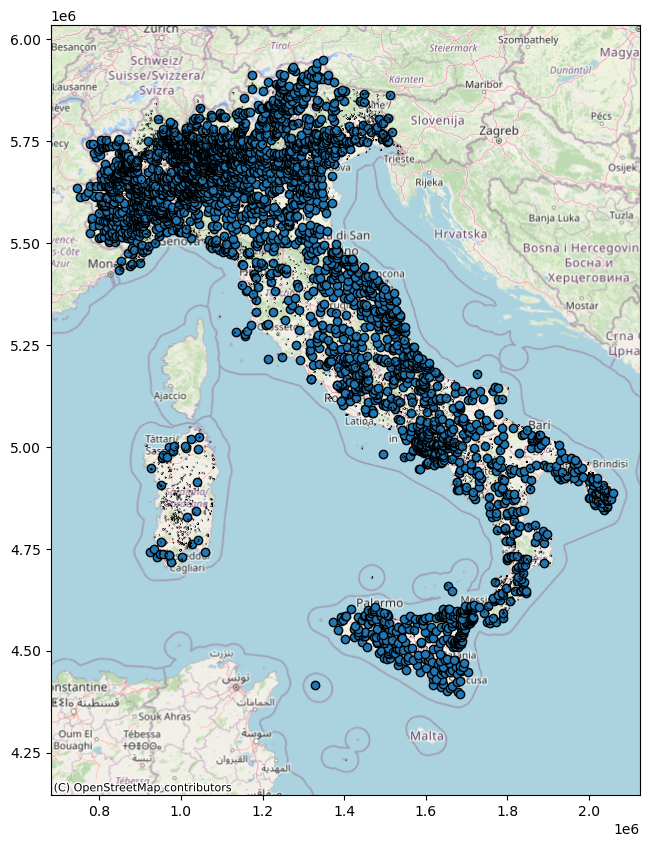

In [19]:
show_map(townhall_gdf)
#show_map(townhall_gdf, municipality_gdf)
#municipality_gdf.explore()
#townhall_gdf.explore()

### Find municipalities without town halls

In [20]:
with_townhall_gdf = townhall_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
with_townhall_gdf.count()

id_hall          8364
osm_id_hall      8364
osm_type_hall    8364
osm_url_hall     8364
name_hall        6657
geometry         8364
index_town       8364
id_town          8364
osm_id_town      8364
osm_type_town    8364
osm_url_town     8364
name_town        8364
dtype: int64

In [21]:
without_townhall_gdf = municipality_gdf[ # Anti-join
        ~municipality_gdf["id"].isin(with_townhall_gdf["id_town"])
    ]
without_townhall_gdf.to_file(WITHOUT_TOWNHALL_FILE_PATH, driver="GeoJSON")
without_townhall_gdf.count()

id          195
osm_id      195
osm_type    195
osm_url     195
name        195
geometry    195
dtype: int64

In [22]:
without_townhall_gdf.head()

id osm_id  osm_type                                       osm_url  \
485  486  41318  relation  https://www.openstreetmap.org/relation/41318   
594  595  41768  relation  https://www.openstreetmap.org/relation/41768   
613  614  41876  relation  https://www.openstreetmap.org/relation/41876   
615  616  41892  relation  https://www.openstreetmap.org/relation/41892   
642  643  41835  relation  https://www.openstreetmap.org/relation/41835   

                     name                                           geometry  
485     Castro dei Volsci  MULTIPOLYGON (((13.43674 41.46096, 13.43578 41...  
594  Castelnuovo di Porto  MULTIPOLYGON (((12.58695 42.07417, 12.5809 42....  
613           Sant'Oreste  MULTIPOLYGON (((12.47803 42.24925, 12.48143 42...  
615        Ponzano Romano  MULTIPOLYGON (((12.55031 42.29351, 12.55171 42...  
642        Fara in Sabina  MULTIPOLYGON (((12.72987 42.21895, 12.73011 42...

Map of municipalities without town hall:

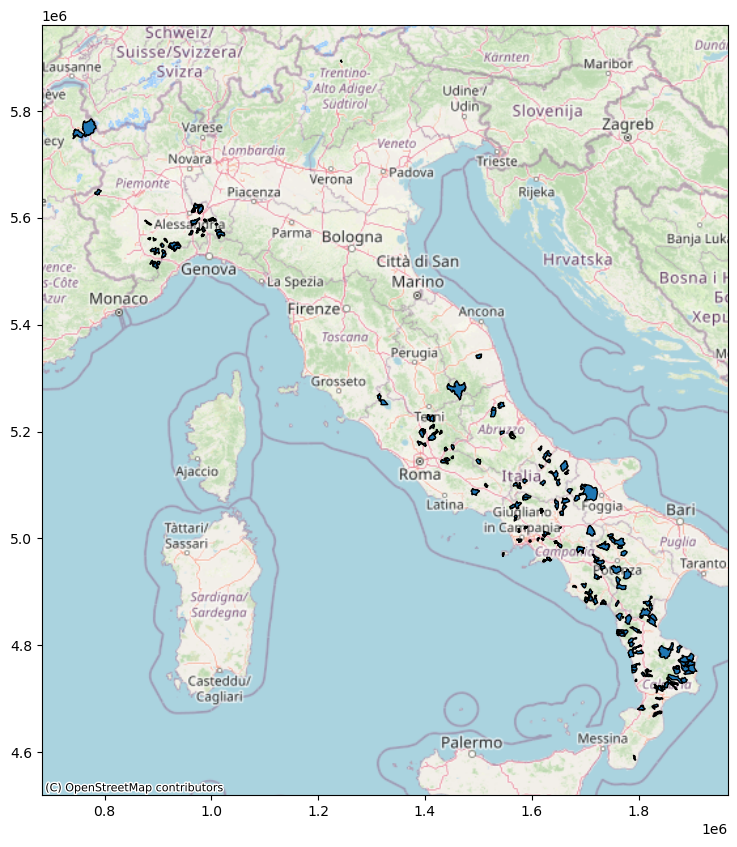

In [23]:
show_map(without_townhall_gdf)
#without_townhall_gdf.explore()

### Calculate statistics for each province

In [24]:
province_municipality_df = province_gdf[["id","geometry"]].sjoin(
        municipality_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_municipalities"] = province_municipality_df.groupby(province_municipality_df.index).count()["index_mun"]

In [25]:
province_without_townhall_df = province_gdf[["id","geometry"]].sjoin(
        without_townhall_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_without_townhall"] = province_without_townhall_df.groupby(province_without_townhall_df.index).count()["index_mun"]

<Axes: >

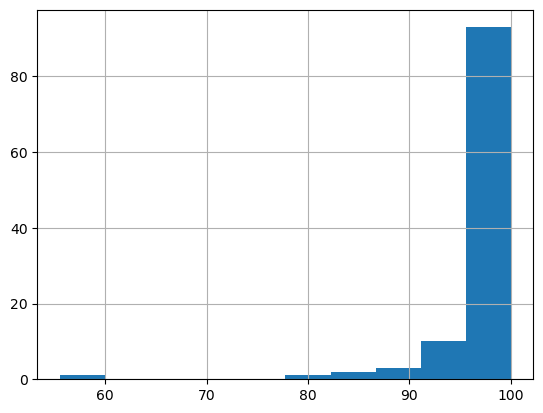

In [26]:
province_gdf["osm_availability"] = 100 * (1 - (province_gdf["num_without_townhall"] / province_gdf["num_municipalities"]))
province_gdf["osm_availability"].hist()

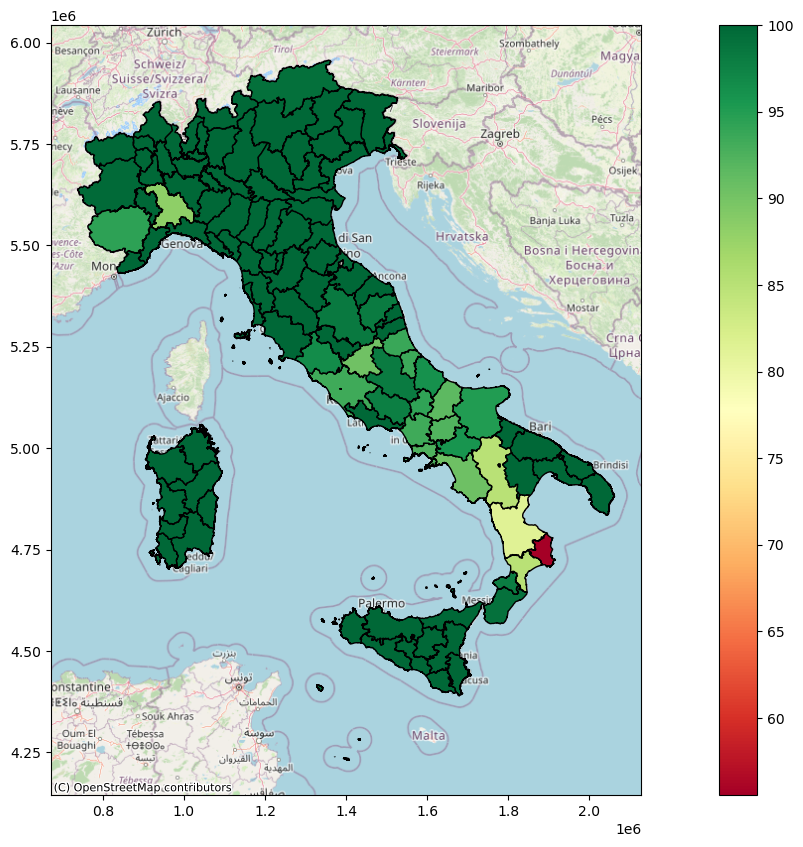

In [27]:
show_map(province_gdf, None, "osm_availability", "RdYlGn")

### Find OSM untagged building named as town halls

In [28]:
UNTAGGED_OVERPASS_QUERY=f"""
[out:json][timeout:300];
area({SEARCH_AREA_ID})->.searchArea;
nwr["building"]["amenity"!="townhall"]["name"~"^(\s|palazzo|del|nuovo|comune|-)*municipio",i](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""
untagged_gdf = readOrFetchOverpassGeoDataFrame(UNTAGGED_FILE_PATH, UNTAGGED_OVERPASS_QUERY)
untagged_gdf.count()

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\danys\AppData\Local\Temp\ipykernel_4840\2183876929.py:8: SyntaxWarning: invalid escape sequence '\s'
  untagged_gdf = readOrFetchOverpassGeoDataFrame(UNTAGGED_FILE_PATH, UNTAGGED_OVERPASS_QUERY)
c:\Users\danys\.conda\envs\gis\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


id          32
osm_id      32
osm_type    32
osm_url     32
name        32
geometry    32
dtype: int64

In [29]:
untagged_gdf.head()

id      osm_id osm_type                                       osm_url  \
0   1   933053288      way   https://www.openstreetmap.org/way/933053288   
1   2    60145522      way    https://www.openstreetmap.org/way/60145522   
2   3   429865034      way   https://www.openstreetmap.org/way/429865034   
3   4  1210024846      way  https://www.openstreetmap.org/way/1210024846   
4   5   566125177      way   https://www.openstreetmap.org/way/566125177   

                                                name  \
0                                          Municipio   
1                                          Municipio   
2                                Municipio di Norcia   
3                  Municipio di Vallelunga Pratameno   
4  Municipio di Rometta-Ufficio decentrato di Rom...   

                                            geometry  
0  LINESTRING (13.09184 37.95253, 13.09212 37.952...  
1  LINESTRING (12.955 41.58178, 12.95523 41.5819,...  
2  LINESTRING (13.09302 42.79263, 13.09313 42.792...  
3  LINESTRING (13.83143 37.68166, 13.83128 37.681...  
4  LINESTRING (15.40392 38.23084, 15.40407 38.230...

In [30]:
untagged_missing_gdf = untagged_gdf.sjoin(
        without_townhall_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
untagged_missing_gdf.count()

id_hall          2
osm_id_hall      2
osm_type_hall    2
osm_url_hall     2
name_hall        2
geometry         2
index_town       2
id_town          2
osm_id_town      2
osm_type_town    2
osm_url_town     2
name_town        2
dtype: int64

In [31]:
untagged_missing_gdf.head()

id_hall osm_id_hall osm_type_hall  \
2         3   429865034           way   
11       12   459081887           way   

                                   osm_url_hall            name_hall  \
2   https://www.openstreetmap.org/way/429865034  Municipio di Norcia   
11  https://www.openstreetmap.org/way/459081887            Municipio   

                                             geometry  index_town  id_town  \
2   LINESTRING (13.09302 42.79263, 13.09313 42.792...         913      914   
11  LINESTRING (15.50748 40.59844, 15.50756 40.598...        2331     2332   

   osm_id_town osm_type_town                                  osm_url_town  \
2        42127      relation  https://www.openstreetmap.org/relation/42127   
11       40618      relation  https://www.openstreetmap.org/relation/40618   

            name_town  
2              Norcia  
11  Vietri di Potenza

In [32]:
untagged_missing_gdf.to_file(UNTAGGED_MISSING_FILE_PATH, driver='GeoJSON')

In [33]:
#show_map(untagged_missing_gdf)
untagged_missing_gdf.explore()

### Find elements wrongly mapped as town halls

In [34]:
bad_townhall_mask = Series(False, index=townhall_gdf.index)
for word in ["consorzio","uffici"]:
    bad_townhall_mask |= townhall_gdf["name"].str.lower().str.contains(word, na=False)
bad_townhall_mask.value_counts()

False    8316
True       44
Name: count, dtype: int64

In [35]:
bad_townhall_gdf = townhall_gdf[bad_townhall_mask]
bad_townhall_gdf.to_file(BAD_TOWNHALLS_FILE_PATH, driver='GeoJSON')
bad_townhall_gdf.explore()

## Step 2: Obtain the data from DBSN

Download the data from IGM DBSN ( https://www.igmi.org/it/dbsn-database-di-sintesi-nazionale ).

Then extract the catageory of elements you are interested in and save it as GeoJSON with EPSG 4326 SRID.
To accomplish you can use the script "filtra_dbsn.sh" in the project repository root (or https://www.dsantini.it/dbsn/filtra_dbsn.sh ).
The file downloaded below from dbsn_url has been generated with this script. 

## Step 3: Analyse useful data from DBSN

### Find possible town halls from DBSN

#### Download DBSN data on town halls

In [36]:
def download_file_if_not_exists(file_path, url):
    if not exists(file_path):
        try: 
            urlretrieve(url, file_path)
        except HTTPError as err:
            print("Failed downloading data from Overpass, retry later")
            raise err

In [37]:
# https://www.dsantini.it/dbsn/
dbsn_url = "https://www.dsantini.it/dbsn/notebooks/dbsn_townhalls.geojson"
download_file_if_not_exists(DBSN_FILE_PATH, dbsn_url)

In [38]:
dbsn_gdf = read_file(DBSN_FILE_PATH)
dbsn_gdf.count()


edifc_uso       8316
edifc_ty        8316
edifc_sot       8316
edifc_nome      8316
edifc_stat      8316
edifc_at        8313
scril           7970
meta_ist        8316
edifc_mon       8316
classid         8316
shape_Length    8316
shape_Area      8316
geometry        8316
dtype: int64

In [39]:
dbsn_gdf.head()

edifc_uso edifc_ty edifc_sot                             edifc_nome  \
0      0201       01        01                  Municipio di Caulonia   
1      0201       01        01           Municipio di Roccella Ionica   
2      0201       01        01  Municipio di Marina di Gioiosa Ionica   
3      0201       01        01                   Municipio di Martone   
4      0201       01        01            Municipio di Gioiosa Ionica   

  edifc_stat  edifc_at scril meta_ist edifc_mon  \
0         03   -9999.0  5000       04        02   
1         03   -9999.0  5000       04        02   
2         03   -9999.0  5000       04        02   
3         03   -9999.0  5000       04        02   
4         03   -9999.0  5000       04        02   

                                  classid  shape_Length  shape_Area  \
0  {4D06FC09-ED09-42D5-ABCC-F5A038E17A1A}    102.506956  437.506943   
1  {4EFA7CB7-5099-4B85-8AC7-DBD7031C2473}    125.122047  693.916957   
2  {CB0D57BC-303F-4BEF-B8B5-CCB9CF14569D}    122.168508  645.982945   
3  {B664EE9E-CA71-41CC-8B85-F7FDFACDBF64}     68.200286  271.429851   
4  {99141ABC-BA82-4B54-B337-4D6AA40B6A38}    107.791311  446.751886   

                                            geometry  
0  MULTIPOLYGON Z (((16.41107 38.38278 229, 16.41...  
1  MULTIPOLYGON Z (((16.40379 38.32436 20, 16.403...  
2  MULTIPOLYGON Z (((16.32985 38.30085 11, 16.329...  
3  MULTIPOLYGON Z (((16.28769 38.35225 306, 16.28...  
4  MULTIPOLYGON Z (((16.30249 38.33679 119, 16.30...

#### Town statistics for DBSN

In [40]:
municipality_dbsn_gdf = municipality_gdf[["id","geometry"]].sjoin(
        dbsn_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="mun",
        rsuffix="dbsn"
    )
municipality_gdf["dbsn_townhall_num"] = municipality_dbsn_gdf.groupby(municipality_dbsn_gdf.index).count()["index_dbsn"]

<Axes: >

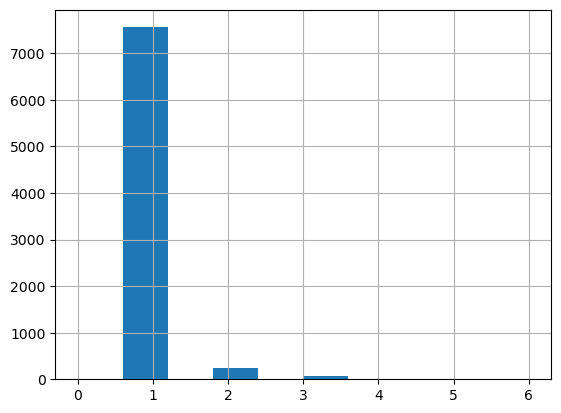

In [41]:
municipality_gdf["dbsn_townhall_num"].hist()

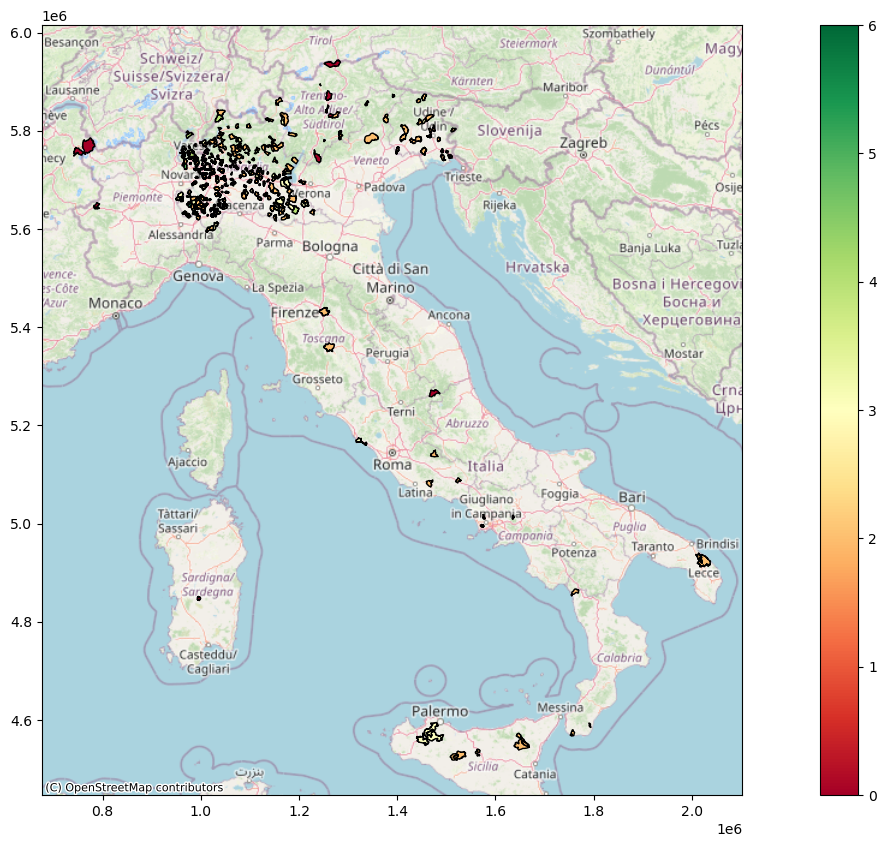

In [42]:
show_map(municipality_gdf[municipality_gdf["dbsn_townhall_num"] != 1], None, "dbsn_townhall_num", "RdYlGn")

#### Province statistics for DBSN

In [43]:
province_dbsn_df = province_gdf[["id","geometry"]].sjoin(
        dbsn_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="dbsn"
    )
province_gdf["dbsn_townhall_num"] = province_dbsn_df.groupby(province_dbsn_df.index).count()["index_dbsn"]

<Axes: >

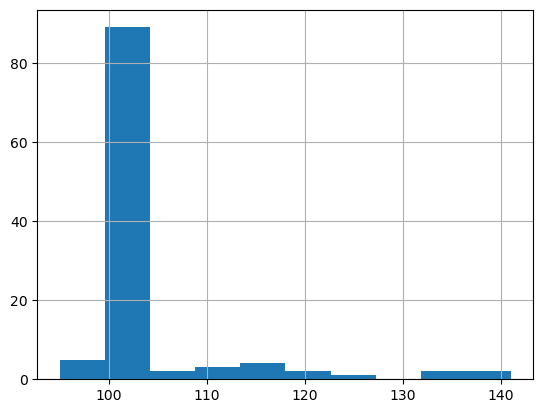

In [44]:
province_gdf["dbsn_availability"] = (100 * (province_gdf["dbsn_townhall_num"] / province_gdf["num_municipalities"])).astype(int)
province_gdf["dbsn_availability"].hist()

In [45]:
show_map(province_gdf[province_gdf["dbsn_availability"] != 100], None, "dbsn_availability", "RdYlGn")

In [46]:
province_gdf[["id","name","dbsn_townhall_num","num_municipalities","dbsn_availability"]].to_csv("province_stats.csv")

#### Compare existing town halls from OSM and DBSN

In [47]:
dbsn_existing_df = dbsn_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="dbsn",
        rsuffix="town"
    )
dbsn_existing_df.count()

edifc_uso            8306
edifc_ty             8306
edifc_sot            8306
edifc_nome           8306
edifc_stat           8306
edifc_at             8303
scril                7973
meta_ist             8306
edifc_mon            8306
classid              8306
shape_Length         8306
shape_Area           8306
geometry             8306
index_town           8306
id                   8306
osm_id               8306
osm_type             8306
osm_url              8306
name                 8306
dbsn_townhall_num    8306
dtype: int64

In [48]:
compare_gdf = merge(
    dbsn_existing_df,
    with_townhall_gdf,
    how="inner",
    left_on="index_town",
    right_on="index_town"
)
compare_gdf.count()

edifc_uso            8864
edifc_ty             8864
edifc_sot            8864
edifc_nome           8864
edifc_stat           8864
edifc_at             8861
scril                8478
meta_ist             8864
edifc_mon            8864
classid              8864
shape_Length         8864
shape_Area           8864
geometry_x           8864
index_town           8864
id                   8864
osm_id               8864
osm_type             8864
osm_url              8864
name                 8864
dbsn_townhall_num    8864
id_hall              8864
osm_id_hall          8864
osm_type_hall        8864
osm_url_hall         8864
name_hall            7076
geometry_y           8864
id_town              8864
osm_id_town          8864
osm_type_town        8864
osm_url_town         8864
name_town            8864
dtype: int64

In [49]:
compare_gdf["distance"] = compare_gdf["geometry_x"].to_crs(epsg=3857).distance(
    compare_gdf["geometry_y"].to_crs(epsg=3857)
  )
compare_gdf["geometry"] = compare_gdf.apply(
    lambda row: LineString([row['geometry_x'].centroid, row['geometry_y'].centroid]),
    axis=1
  ).set_crs(epsg=4326)

In [50]:
compare_gdf.hist(log=True, column="distance")

array([[<Axes: title={'center': 'distance'}>]], dtype=object)

In [51]:
conflict_mask=compare_gdf["distance"] > 1000
for word in [
        "delegazione",
        "circoscrizione",
        "quartiere",
        "frazione",
        "municipalit",
        "municipio roma",
        "consorzio",
        "° municipio",
        "uffici",
        "sede di",
        "distaccat"
    ]:
    conflict_mask &= ~(compare_gdf["name_hall"].str.lower().str.contains(word, na=False))
conflict_mask.value_counts()

distance
False    8546
True      318
Name: count, dtype: int64

In [52]:
dbsn_conflict_gdf = compare_gdf[conflict_mask]
dbsn_conflict_gdf["name_hall"].dropna().drop_duplicates()

65                    Comune di Reggio Calabria
69                  Municipio di Saline Ioniche
75                         Municipio di Roghudi
77           Municipio di Melito di Porto Salvo
151                     Municipio di Bisacquino
                         ...                   
7820                    Municipio di Val di Chy
7872                    Municipio Palazzo Pella
8249    Sede "Parco Regionale Alta Valle Pesio"
8400                  Comune di Montalto Ligure
8742                             Palazzo Civico
Name: name_hall, Length: 185, dtype: object

In [53]:
dbsn_conflict_gdf.explore()

In [54]:
dbsn_conflict_gdf.drop(["geometry_x", "geometry_y"], axis=1).to_file(DBSN_CONFLICTS_FILE_PATH, driver="GeoJSON")

#### Getting missing town halls from Public Data

In [55]:
dbsn_missing_df = dbsn_gdf.sjoin(
    without_townhall_gdf,
    how="inner",
    predicate="within"
)
dbsn_missing_df.count()

edifc_uso       189
edifc_ty        189
edifc_sot       189
edifc_nome      189
edifc_stat      189
edifc_at        188
scril           188
meta_ist        189
edifc_mon       189
classid         189
shape_Length    189
shape_Area      189
geometry        189
index_right     189
id              189
osm_id          189
osm_type        189
osm_url         189
name            189
dtype: int64

In [56]:
dbsn_missing_df.head()

edifc_uso edifc_ty edifc_sot                       edifc_nome edifc_stat  \
463      0201       01        01     Municipio di Serrara Fontana         03   
479      0201       01        01           Municipio di Sparanise         03   
521      0201       01        01   Municipio di Macerata Campania         03   
611      0201       01        01  Municipio di San Paolo Bel Sito         03   
614      0201       01        01              Municipio di Tufino         03   

     edifc_at scril meta_ist edifc_mon  \
463   -9999.0  5000       04        02   
479   -9999.0  5000       04        02   
521   -9999.0  5000       04        02   
611   -9999.0  5000       04        02   
614   -9999.0  5000       04        02   

                                    classid  shape_Length   shape_Area  \
463  {033A1C6B-583F-42FC-A42A-1E02EA8E2282}     71.734167   262.754856   
479  {77134CDA-FD0E-4C97-90E1-D4CB049EA38C}    261.290619  1303.422711   
521  {3C583633-7685-4E5C-ACC2-EEB403AF4EA0}    125.773372   552.875000   
611  {98DB4016-0D3F-4D03-A3BC-822BC4CA69CD}    191.847259  1023.500000   
614  {DB0C02F6-4039-47F5-A2F5-63632C7F31BC}    175.785089  1427.625000   

                                              geometry  index_right    id  \
463  MULTIPOLYGON Z (((13.89573 40.71246 387, 13.89...         1706  1707   
479  MULTIPOLYGON Z (((14.09633 41.19087 0, 14.0962...         1882  1883   
521  MULTIPOLYGON Z (((14.27455 41.06315 0, 14.2745...         1817  1818   
611  MULTIPOLYGON Z (((14.549 40.91432 54, 14.54902...         1996  1997   
614  MULTIPOLYGON Z (((14.56304 40.95476 94, 14.563...         2027  2028   

    osm_id  osm_type                                       osm_url  \
463  40699  relation  https://www.openstreetmap.org/relation/40699   
479  41124  relation  https://www.openstreetmap.org/relation/41124   
521  41053  relation  https://www.openstreetmap.org/relation/41053   
611  40883  relation  https://www.openstreetmap.org/relation/40883   
614  40937  relation  https://www.openstreetmap.org/relation/40937   

                   name  
463     Serrara Fontana  
479           Sparanise  
521   Macerata Campania  
611  San Paolo Bel Sito  
614              Tufino

In [57]:
dbsn_missing_df.to_file(DBSN_MISSING_FILE_PATH, driver="GeoJSON")

In [58]:
#%pip install folium matplotlib mapclassify
dbsn_missing_df.explore()